# Test: Which weights in the error function are well suited for the density fitting?

In [7]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [121]:
'''Scaled normal distribution'''
class scaled_norm():
    def __init__(self, ends_zero=True):
        self.ends_zero = ends_zero
        
    def func(x, scale, mu, sigma):
        return scale * norm(mu, sigma).pdf(x)
    
    def weighted_dist(weights, points_x, points_y, params):
        return (((scaled_norm.func(points_x, *params) - points_y)**2) * weights).sum()

    def fit(self, points_x, points_y, weights):#, data):
        d_mean = points_x[np.argmax(points_y)]  # highest bin
        #d_std = np.sqrt( np.sum((np.array(data) - d_mean)**2) / (len(data) - 1) )
        d_std = 0.05
        d_scale = max(points_y) / max(scaled_norm.func(points_x, 1, d_mean, d_std))
        p0 = np.array([d_scale, d_mean, d_std])  # initial parameters
        optimize_me = lambda p: weighted_dist(weights, points_x, points_y, p)
        if self.ends_zero:
            weights[0] = weights[-1] = d_scale * 0.4
        try:
            bounds = [[0.5*d_scale, 2*d_scale], [points_x[0], points_x[-1]], [0,(points_x[-1]-points_x[0])/2]]
            res = minimize(optimize_me, p0, method='SLSQP', bounds=bounds)
            return scaled_norm.func(points_x, *res.x)
        except:
            #print("pdf fitting with sigma was not successful")
            return np.array(points_y)

In [85]:
def weight_experiment(weights):
    sn = scaled_norm()
    fit = sn.fit(xdata, ydata, weights)

    plt.scatter(xdata, ydata, c='red')
    plt.plot(xdata, fit)
    plt.show()

# Data entirely missing for x>5
Given a histogram (bin positions in xdata, heights in ydata), we consider the area $x\leq 5$ as the true data and want to reconstruct the histogram heights for $x>6$ in a way that we obtain a Gaussian closely fit to the bins of the true data.

In [74]:
xdata = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])
ydata = np.array([0.1, 0.3, 0.7, 1.9, 2.4, 2.6, 0.0, 0.0, 0.0, 0.0])

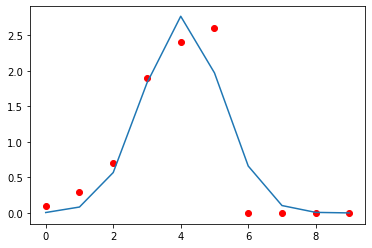

In [75]:
weights = [1] * len(xdata) # equal weights for all bins
weight_experiment(weights)

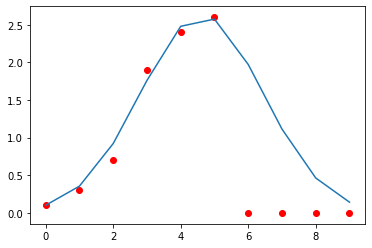

In [60]:
weights = ydata # weight equals bin height
weight_experiment(weights)

The fitting works fine since x>5 does not contribute to the error. But what if it is less clear?

# Data = 0.5 for x>5

In [66]:
ydata = np.array([0.1, 0.3, 0.7, 1.9, 2.4, 2.6, 0.5, 0.5, 0.5, 0.5])

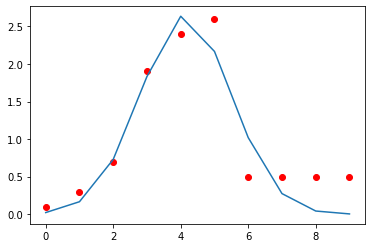

In [67]:
weights = [1] * len(xdata)
weight_experiment(weights)

As we can see here, the points for x>5 contribute too much and the curve is not very well fitted for x=5. We need to give more weight to the present data (i.e., the high histogram bins) and less to the unsure data (i.e., the low histogram bins).

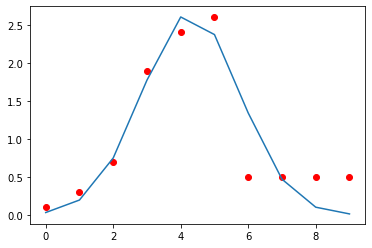

In [68]:
weights = ydata
weight_experiment(weights)

Using the histogram heights as weights, we achieve a shift towards the higher bins, but we want to make it more extreme.

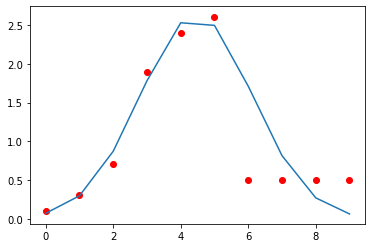

In [69]:
weights = ydata**2
weight_experiment(weights)

The datapoints that we consider the "true" data ($x\leq5$) are fitted well whereas on the "missing" side ($x>5$) some reconstruction took place.

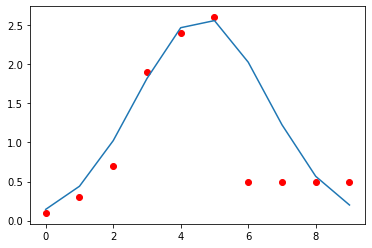

In [70]:
weights = ydata**3
weight_experiment(weights)

If the exponent is raised further, we stop fitting the "true" small datapoints ($x\leq 2$) very well. That is not what we want, so we decide not to raise the exponent over $2$.